# Time Leading, Traing Ties v2.0
- Started 11-11-24

In [19]:
### DEPENDENCIES
#### Python 3.8.10
#### BASIC
import os
import sqlite3
import pandas as pd
import numpy as np
from collections import defaultdict


# PLOTTING
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.legend_handler import HandlerTuple
from matplotlib.legend_handler import HandlerBase

#### IMAGE PROCESSING
from PIL import Image

#### WEB SCRAPING
from bs4 import BeautifulSoup
import requests

######
##### DB PATH IMPORT
## Get DB path and last game date from global settings
from config import recent_clean_db, last_game_date

## Set Standard Figure Size (right now just used for scatter plot)
top_fig_size = (9, 12) # Top Figure Size

db_path = recent_clean_db # Database Path


conn = sqlite3.connect(db_path) # Connect to the database
# verify the connection
cursor = conn.cursor() 
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# extract scoring table from database
scoring_query = "SELECT * FROM scoring_summary"
scoring_df = pd.read_sql_query(scoring_query, conn)

# Clean Up Team names
# Drop any non-letter characters from the Team, Away_Team, and Home_Team columns
scoring_df['Team'] = scoring_df['Team'].str.replace(r'[^a-zA-Z]', '')
scoring_df['Away_Team'] = scoring_df['Away_Team'].str.replace(r'[^a-zA-Z]', '')
scoring_df['Home_Team'] = scoring_df['Home_Team'].str.replace(r'[^a-zA-Z]', '')

# scoring_df.head()

In [20]:
## File Paths
folder_prefix = ''
# folder_prefix = '..'
data_folder = os.path.join(folder_prefix, '..', 'data/') # Data Folder Path
temp_folder = os.path.join(folder_prefix,'..', 'TEMP/',) # Temp Folder Path
TEMP_FOLDER = temp_folder # Temp Folder Path as used in legacy code
output_folder = os.path.join(temp_folder, 'team_comp_output/') # Output Folder Path
output_file_path = os.path.join(output_folder, 'team_comp_output.csv') # Output File Path
# data\db\2024_Dec_10_CLEANED_OLD_METHOD.db
# db_path = os.path.join(data_folder, 'db', '2025_Jan_26_CLEAN.db') # Database Path
db_path = recent_clean_db # Database Path

image_folder = os.path.join(folder_prefix, '..', 'images/') # Image Folder Path
logo_folder = os.path.join(folder_prefix, image_folder, 'logos/') # Logo Folder Path
conference_logo_folder = os.path.join(folder_prefix, logo_folder, 'conference') # Conference Logo Folder Path
export_folder = os.path.join(folder_prefix, image_folder, 'export/') # Export Folder Path
background_folder = os.path.join(folder_prefix, image_folder, 'background/') # Background Folder Path

# Other paths
school_info_path = os.path.join(data_folder, 'arena_school_info.csv') # School Info Path


#### Merge in conference game game type 

In [21]:
## get the game_details table from the database
# Grab Date, Game_ID, Conference
game_details_query = "SELECT Date, Game_ID, Conference FROM game_details"
game_details_df = pd.read_sql_query(game_details_query, conn)
# game_details_df.head()

# Merge the game_details_df with the scoring_df on Game_ID
merged_df = pd.merge(scoring_df, game_details_df, on='Game_ID')
merged_df.head()

# Rename merged_df to the original name of scoring_df
scoring_df = merged_df.copy()

In [22]:
# scoring_df.head()

### Dictionaries and Constants

In [23]:
# path to TEMP folder
temp_folder = os.path.join(os.getcwd(), '..', 'TEMP')
# Direct to tie_plot OUTPUT folder 
tie_plot_folder = os.path.join(temp_folder, 'IMAGES', 'tie_plots')
# Data folder
data_folder = os.path.join(os.getcwd(), '..', 'data')
# Image folder
img_folder = os.path.join(os.getcwd(), '..', 'images')
# Logo folder
logo_folder = os.path.join(os.getcwd(), '..', 'images', 'logos')

# Path to school info table (csv)
school_info_file = os.path.join(data_folder, 'arena_school_info.csv')
school_info_df = pd.read_csv(school_info_file)

## Conference Membership

atlantic = ['Air Force', "American Intl", 'Army', 'Bentley', 'Canisius', 'Holy Cross', 'Mercyhurst', 
            'Niagara', 'RIT', 'Robert Morris', 'Sacred Heart']

big_ten = ['Michigan', 'Michigan State', 'Minnesota', 'Notre Dame', 'Ohio State', 'Penn State', 'Wisconsin']

ccha = ['Augustana', 'Bemidji State', 'Bowling Green', 'Ferris State', 'Lake Superior', 'Michigan Tech', 
        'Minnesota State', 'Northern Michigan', 'St Thomas']

ecac = ['Brown', 'Clarkson', 'Colgate', 'Cornell', 'Dartmouth', 'Harvard', 'Princeton', 'Quinnipiac',
        'Rensselaer', 'St Lawrence', 'Union', 'Yale']

hockey_east = ['Boston College', 'Boston University', 'Connecticut', 'Maine', 'Massachusetts', 'Mass Lowell',
                'Merrimack', 'New Hampshire', 'Northeastern', 'Providence', 'Vermont']

nchc = ['Arizona State', 'Colorado College', 'Denver', 'Miami', 'Minnesota Duluth', 'North Dakota', 'Omaha', 'St Cloud State',
        'Western Michigan']

independents = ['Alaska Anchorage', 'Alaska', 'Lindenwood', 'Long Island', 'Stonehill']

# Create a dictionary of {Team: logo_abv} for each team with .png added to the end
logo_mapping = {}

for index, row in school_info_df.iterrows():
    logo_mapping[row['Team']] = row['logo_abv'] + '.png'

# print(logo_mapping)

In [24]:
title_font_size = 28
legend_title_font_size = 24
legend_font_size = 20
legend_font_size_2 = 16
set_x_label_font_size = 16
set_x_label_font_size_2 = 18

##### TRANFORMATION - HELPERS FUNCTIONS

In [25]:
# Step 1: Preprocess the data to convert 'Time' and 'Period' into cumulative seconds
def convert_time_to_seconds(time_str):
    """Convert 'MM:SS' format to total seconds."""
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds

def convert_period_to_seconds(period, time_in_period):
    """Convert period and time in period to cumulative game seconds."""
    base_time = 0
    if period == '1st Period':
        base_time = 0
    elif period == '2nd Period':
        base_time = 1200  # 20 minutes
    elif period == '3rd Period':
        base_time = 2400  # 40 minutes
    elif period == 'Overtime':
        base_time = 3600  # 60 minutes (end of regulation)
    return base_time + time_in_period

# Apply the conversions to the dataframe
scoring_df['Time_Seconds'] = scoring_df['Time'].apply(convert_time_to_seconds)
scoring_df['Cumulative_Seconds'] = scoring_df.apply(
    lambda row: convert_period_to_seconds(row['Period'], row['Time_Seconds']), axis=1
)

# Sort the dataframe by Game_ID and Cumulative_Seconds to process goals in order
scoring_df.sort_values(by=['Game_ID', 'Cumulative_Seconds'], inplace=True)

# Display the processed dataframe to check the conversion results
# import ace_tools as tools; tools.display_dataframe_to_user(name="Processed Scoring Data", dataframe=scoring_df)


#### HOTFIX FOR PUNCTUATION IN TEAM NAME ISSUES

In [26]:
## Hotfix for Recurring issue where St Lawrence is listed as 'St. Lawrence' in the Home_Team and Away_Team columns
scoring_df['Home_Team'] = scoring_df['Home_Team'].replace('St. Lawrence', 'St Lawrence')
scoring_df['Away_Team'] = scoring_df['Away_Team'].replace('St. Lawrence', 'St Lawrence')

# Remove any "." characters from the Team, Away_Team, and Home_Team columns and Replace with ""
scoring_df['Team'] = scoring_df['Team'].str.replace('.', '', regex=False)
scoring_df['Away_Team'] = scoring_df['Away_Team'].str.replace('.', '', regex=False)
scoring_df['Home_Team'] = scoring_df['Home_Team'].str.replace('.', '', regex=False)
# Remove "'" characters from the Team, Away_Team, and Home_Team columns and Replace with ""
scoring_df['Team'] = scoring_df['Team'].str.replace("'", '', regex=False)
scoring_df['Away_Team'] = scoring_df['Away_Team'].str.replace("'", '', regex=False)
scoring_df['Home_Team'] = scoring_df['Home_Team'].str.replace("'", '', regex=False)

 

## ADD/REMOVE FILTER FOR CONFERENCE GAMES

In [27]:
########################### CONFERENCE FILTER ###########################

## Set File Tag
## Global setting for conference vs non conference tagg for files
conf_setting = 'all' # leave as 'all' for plots of all games
# conf_setting = 'conf' # set to 'conf' for plots of just conference games
# conf_setting = 'non' # set to 'non' for plots of just non conference games 



########### TURN ON TO ONLY LOOK AT CONFERENCE GAMES ###########
####### IN CONFERENCE ######
#### Filter to just inter conference games ###
conf_ids = ['Atlantic Hockey Game', 'Big Ten Game', 
            'CCHA Game', 'ECAC Game', 'Hockey East Game', 'NCHC Game']

# If Conf setting is 'all', do nothing

# If Conf setting is 'conf', filter to just conference games
if conf_setting == 'conf':
    scoring_df = scoring_df[scoring_df['Conference'].isin(conf_ids)]
# If Conf setting is 'non', filter to just non conference games
if conf_setting == 'non':
    scoring_df = scoring_df[~scoring_df['Conference'].isin(conf_ids)]



scoring_data = scoring_df.copy()
#######################################################################



# #########################################################################
# ########### NON CONFERENCE GAMES ONLY ###################################
# ###### Remove conference games from the dataframe
# conf_ids = ['Atlantic Hockey Game', 'Big Ten Game', 
#             'CCHA Game', 'ECAC Game', 'Hockey East Game', 'NCHC Game']
# scoring_df = scoring_df[~scoring_df['Conference'].isin(conf_ids)] 
########### Filter to just non conference games #########################

In [28]:
## Function to Add Annotation with Tag for Conference Filter

def add_conf_tag_to_image(conf_setting):
    """
    Adds a text tag in the upper right corner above the title of the figure
    based on the conf_setting.

    Parameters:
    - conf_setting: String, either "all", "conf", or "non-conf".
    """
    if conf_setting == "conf":
        tag_text = "Conference Games Only"
    elif conf_setting == "non":
        tag_text = "Non-Conference Games"
    elif conf_setting == "all":
        tag_text = "All Games"
    else:
        return  # No annotation needed if conf_setting is "all"

    plt.text(
        0.99, 1.08,  # Position slightly above the title
        tag_text,
        ha='right', va='bottom',
        fontsize=14, fontweight='bold',
        transform=plt.gca().transAxes
    )

def add_conf_tag_to_image_tall_ver(conf_setting):
    """
    Adds a text tag in the upper right corner above the title of the figure
    based on the conf_setting.

    Parameters:
    - conf_setting: String, either "all", "conf", or "non-conf".
    """
    if conf_setting == "conf":
        tag_text = "Conference Games Only"
    elif conf_setting == "non":
        tag_text = "Non-Conference Games"
    elif conf_setting == "all":
        tag_text = "All Games"
    else:
        return  # No annotation needed if conf_setting is "all"

    plt.text(
        0.99, 1.02,  # Position slightly above the title
        tag_text,
        ha='right', va='bottom',
        fontsize=14, fontweight='bold',
        transform=plt.gca().transAxes
    )


In [29]:
# scoring_df.head()

## Leading-Tie-Trailing Transition Plot

### CREATE GAME STATE TRANSITION TABLE - Data Transformation
- use the df in its current state to do analyis of teams leading and trailing events

In [30]:


# === Immediate Transition Counters ===
tie_to_lead_counts   = defaultdict(int)  # e.g., team scores from a tie to take a 1-goal lead
tie_to_trail_counts  = defaultdict(int)  # e.g., team goes from tie to falling behind (rare for the scoring team)
lead_to_tie_counts   = defaultdict(int)  # e.g., opponent loses a 1-goal lead as the score becomes tied
trail_to_tie_counts  = defaultdict(int)  # e.g., team scores from a 1-goal deficit to tie

# === Extended Comeback / Collapse Counters ===
comeback_2_counts   = defaultdict(int)  # team comes back from exactly a 2-goal deficit (ties the game)
comeback_3_counts   = defaultdict(int)  # team comes back from a 3+ goal deficit (ties the game)
collapse_2_counts   = defaultdict(int)  # team loses a 2-goal lead (game eventually tied)
collapse_3_counts   = defaultdict(int)  # team loses a 3+ goal lead (game eventually tied)

# === Total Goals Tally ===
total_goals_for     = defaultdict(int)
total_goals_against = defaultdict(int)

# === Final Game Outcome Counters ===
team_wins   = defaultdict(int)
team_loses  = defaultdict(int)
team_ties   = defaultdict(int)

# === Outcome After Momentum Counters ===
team_wins_after_trailing   = defaultdict(int)
team_ties_after_trailing   = defaultdict(int)
team_loses_after_leading   = defaultdict(int)
team_ties_after_leading    = defaultdict(int)
team_loses_after_trailing  = defaultdict(int)
team_wins_after_leading    = defaultdict(int)

# === NEW: Game-Level Counters ===
# Count total games played per team, and in how many games they led or trailed at some point.
total_games_played = defaultdict(int)
total_games_lead   = defaultdict(int)
total_games_behind = defaultdict(int)

# === Process Each Game ===
for game_id, game_data in scoring_data.groupby("Game_ID"):
    # Sort scoring events chronologically
    game_data_sorted = game_data.sort_values(by="Cumulative_Seconds")
    
    # Identify the two teams (assumes these remain constant within a game)
    away_team = game_data_sorted["Away_Team"].iloc[0]
    home_team = game_data_sorted["Home_Team"].iloc[0]
    teams = [away_team, home_team]
    
    # Initialize running scores for each team
    scores = {team: 0 for team in teams}
    
    # ----- Period Tracking (for tie-to-tie sequences) -----
    # These help count comeback/collapse events when the game returns to a tie.
    period_min_diff = {team: 0 for team in teams}  # lowest differential (from that team’s perspective)
    period_max_diff = {team: 0 for team in teams}  # highest differential
    
    # ----- Game-Level Tracking (for overall momentum) -----
    # We track the overall minimum and maximum differential in the game.
    game_min_diff = {team: 0 for team in teams}
    game_max_diff = {team: 0 for team in teams}
    
    # Process each scoring event
    for _, row in game_data_sorted.iterrows():
        scoring_team = row["Team"]
        opposing_team = [t for t in teams if t != scoring_team][0]
        
        # Pre-goal differences (from scoring team’s perspective)
        diff_scoring_before = scores[scoring_team] - scores[opposing_team]
        diff_opponent_before = scores[opposing_team] - scores[scoring_team]
        
        # Update score: scoring team adds one goal
        scores[scoring_team] += 1
        
        # Post-goal differences
        diff_scoring_after = scores[scoring_team] - scores[opposing_team]
        diff_opponent_after = scores[opposing_team] - scores[scoring_team]  # negative of diff_scoring_after
        
        # --- Immediate Transitions ---
        if diff_scoring_before == 0 and diff_scoring_after == 1:
            tie_to_lead_counts[scoring_team] += 1
        if diff_scoring_before == -1 and diff_scoring_after == 0:
            trail_to_tie_counts[scoring_team] += 1
        if diff_opponent_before == 0 and diff_opponent_after == -1:
            tie_to_trail_counts[opposing_team] += 1
        if diff_opponent_before == 1 and diff_opponent_after == 0:
            lead_to_tie_counts[opposing_team] += 1
        
        # --- Update Period Tracking (for tie-to-tie comeback/collapse events) ---
        period_min_diff[scoring_team] = min(period_min_diff[scoring_team], diff_scoring_after)
        period_max_diff[opposing_team] = max(period_max_diff[opposing_team], diff_opponent_after)
        # Also update for the non-scoring team (for completeness):
        current_diff_opposing = scores[opposing_team] - scores[scoring_team]
        period_min_diff[opposing_team] = min(period_min_diff[opposing_team], current_diff_opposing)
        period_max_diff[scoring_team] = max(period_max_diff[scoring_team], diff_scoring_after)
        
        # --- Update Game-Level Tracking ---
        for team in teams:
            other = [t for t in teams if t != team][0]
            current_diff = scores[team] - scores[other]
            game_min_diff[team] = min(game_min_diff[team], current_diff)
            game_max_diff[team] = max(game_max_diff[team], current_diff)
        
        # --- Close a Tie-to-Tie Period ---
        if scores[scoring_team] == scores[opposing_team]:
            # For the team that scored the tying goal:
            if period_min_diff[scoring_team] <= -2:
                if period_min_diff[scoring_team] == -2:
                    comeback_2_counts[scoring_team] += 1
                elif period_min_diff[scoring_team] <= -3:
                    comeback_3_counts[scoring_team] += 1
            # For the opposing team, check if they lost a significant lead:
            if period_max_diff[opposing_team] >= 2:
                if period_max_diff[opposing_team] == 2:
                    collapse_2_counts[opposing_team] += 1
                elif period_max_diff[opposing_team] >= 3:
                    collapse_3_counts[opposing_team] += 1
            
            # Reset period tracking once the game is tied
            period_min_diff = {team: 0 for team in teams}
            period_max_diff = {team: 0 for team in teams}
    
    # ----- End-of-Game Processing -----
    
    # Update total goals tallies
    for team in teams:
        opposing_team = [t for t in teams if t != team][0]
        total_goals_for[team] += scores[team]
        total_goals_against[team] += scores[opposing_team]
    
    # Determine final outcome (win/loss/tie)
    if scores[away_team] > scores[home_team]:
        team_wins[away_team] += 1
        team_loses[home_team] += 1
    elif scores[away_team] < scores[home_team]:
        team_wins[home_team] += 1
        team_loses[away_team] += 1
    else:
        team_ties[away_team] += 1
        team_ties[home_team] += 1
    
    # Update momentum-related outcome counters using game-level tracking
    for team in teams:
        other = [t for t in teams if t != team][0]
        if scores[team] > scores[other] and game_min_diff[team] < 0:
            team_wins_after_trailing[team] += 1
        if scores[team] < scores[other] and game_max_diff[team] > 0:
            team_loses_after_leading[team] += 1
        if scores[team] == scores[other]:
            if game_min_diff[team] < 0:
                team_ties_after_trailing[team] += 1
            if game_max_diff[team] > 0:
                team_ties_after_leading[team] += 1
        if scores[team] < scores[other] and game_min_diff[team] < 0:
            team_loses_after_trailing[team] += 1
        if scores[team] > scores[other] and game_max_diff[team] > 0:
            team_wins_after_leading[team] += 1

    # --- NEW: Update Game-Level Counters for Games Played, Led, and Trailed ---
    for team in teams:
        total_games_played[team] += 1
        if game_max_diff[team] > 0:
            total_games_lead[team] += 1
        if game_min_diff[team] < 0:
            total_games_behind[team] += 1

# ===== Build the Final Summary DataFrame =====

# Collect all teams from every dictionary
all_teams = (set(tie_to_lead_counts.keys())   | set(tie_to_trail_counts.keys())  |
             set(lead_to_tie_counts.keys())   | set(trail_to_tie_counts.keys()) |
             set(comeback_2_counts.keys())    | set(comeback_3_counts.keys())   |
             set(collapse_2_counts.keys())    | set(collapse_3_counts.keys())   |
             set(total_goals_for.keys())      | set(total_goals_against.keys()) |
             set(team_wins.keys())            | set(team_loses.keys())          |
             set(team_ties.keys())            | set(team_wins_after_trailing.keys()) |
             set(team_ties_after_trailing.keys()) | set(team_loses_after_leading.keys()) |
             set(team_ties_after_leading.keys())  | set(team_loses_after_trailing.keys()) |
             set(team_wins_after_leading.keys())  | set(total_games_played.keys())  |
             set(total_games_lead.keys())     | set(total_games_behind.keys()))
    
summary_df = pd.DataFrame({
    "Team": list(all_teams),
    "Tie_to_Lead":            [tie_to_lead_counts[t] for t in all_teams],
    "Tie_to_Trail":           [tie_to_trail_counts[t] for t in all_teams],
    "Lead_to_Tie":            [lead_to_tie_counts[t] for t in all_teams],
    "Trail_to_Tie":           [trail_to_tie_counts[t] for t in all_teams],
    "2-Goal Comeback_to_tie":       [comeback_2_counts[t] for t in all_teams],
    "3-Goal Comeback_to_tie":       [comeback_3_counts[t] for t in all_teams],
    "2-Goal Collapse_to_tie":       [collapse_2_counts[t] for t in all_teams],
    "3-Goal Collapse_to_tie":       [collapse_3_counts[t] for t in all_teams],
    "Total_goals_for":       [total_goals_for[t] for t in all_teams],
    "Total_goals_against":   [total_goals_against[t] for t in all_teams],
    "Total_Games_Played":    [total_games_played[t] for t in all_teams],
    "Team_Wins":             [team_wins[t] for t in all_teams],
    "Team_Loses":            [team_loses[t] for t in all_teams],
    "Team_Ties":             [team_ties[t] for t in all_teams],
    
    "Total_Games_Trailing":    [total_games_behind[t] for t in all_teams],
    "Wins_after_Trailing":   [team_wins_after_trailing[t] for t in all_teams],
    "Loses_after_Trailing":  [team_loses_after_trailing[t] for t in all_teams],
    "Ties_after_Trailing":   [team_ties_after_trailing[t] for t in all_teams],
    "Total_Games_Leading":      [total_games_lead[t] for t in all_teams],
    "Wins_after_Leading":    [team_wins_after_leading[t] for t in all_teams],
    "Loses_after_Leading":   [team_loses_after_leading[t] for t in all_teams],
    "Ties_after_Leading":    [team_ties_after_leading[t] for t in all_teams],  
})

### Calculate the lead_giveback_pct and trail_comeback_pct columns
summary_df['Lead_Giveback_Pct'] = (summary_df['Lead_to_Tie'] / summary_df['Tie_to_Lead']).replace(np.nan, 0)
summary_df['Trail_Comback_Pct'] = (summary_df['Trail_to_Tie'] / summary_df['Tie_to_Trail']).replace(np.nan, 0)

# print(summary_df)


### Scatter Plot

#### Helper Functions - Font & Figure Settings

In [31]:
## Sub function to use withing plotting functions to place logos
def add_logos_to_plot(data_df, x_col, y_col, logo_mapping, logo_folder, ax, teams_in_region):
    # Plot logos for specific teams
    for team in teams_in_region:
        team_data = data_df[data_df['Team'] == team]
        if not team_data.empty:
            x = team_data[x_col].values[0]
            y = team_data[y_col].values[0]
            logo_path = os.path.join(logo_folder, logo_mapping.get(team, ""))
            if logo_path:
                try:
                    logo_img = plt.imread(logo_path)
                    imagebox = OffsetImage(logo_img, zoom=0.15)  # Adjust zoom as needed
                    ab = AnnotationBbox(imagebox, (x, y), frameon=False, xybox=(0, 0), boxcoords="offset points", pad=0)
                    ax.add_artist(ab)  # Apply the ax here as the artist is being added to ax
                except Exception as e:
                    print(f"Error adding logo for {team}: {e}")

In [32]:
### Set Figure Size (Global)
set_fig_size = top_fig_size

### Font Properties
font = "Exo 2"

font_title_param = {'fontname': font, 'fontsize': 32, 'fontweight': 'bold'}
font_label_param = {'fontname': font, 'fontsize': 28, 'fontweight': 'normal'}
font_scatter_title_param = {'fontname': font, 'fontsize': 24, 'fontweight': 'bold'}
font_scatter_label_param = {'fontname': font, 'fontsize': 20, 'fontweight': 'normal'}


##### Create dictionary of team groups 

In [33]:
### In season Tourney Groups
# Create a list with all 65 D1 Teams
all_teams = list(set(summary_df['Team']))
# create logo map for all teams
all_logo_mapping = {team: logo_mapping.get(team, '') for team in all_teams}


# Four Team Group (GLI)
gli_teams = ['Michigan Tech', 'Western Michigan', 'Michigan State', 'Northern Michigan']
gli_logo_mapping = {team: logo_mapping.get(team, '') for team in gli_teams}

# Four Team Group (Beanpot)
beanpot_teams = ['Boston College', 'Boston University', 'Harvard', 'Northeastern']
beanpot_logo_mapping = {team: logo_mapping.get(team, '') for team in beanpot_teams}

# Kwick Trip Faceoff - Wis hosted Dec 28-29
kwik_trip_teams = ["Wisconsin", "Ferris State", "Connecticut", "Alaska"]
kwik_trip_logo_mapping = {team: logo_mapping.get(team, '') for team in kwik_trip_teams}

# Desert Hockey Classic - ASU hosted Jan 3-4
desert_classic_teams = ["Arizona State", "Robert Morris", "Cornell", "Massachusetts" ]
desert_classic_logo_mapping = {team: logo_mapping.get(team, '') for team in desert_classic_teams}

# Auld Lang Syne - Dec 28-29
auld_lang_teams = ["Dartmouth", "Alaska Anchorage", "Northeastern", "Providence"]
auld_lang_logo_mapping = {team: logo_mapping.get(team, '') for team in auld_lang_teams}


### Call the Appropriate Group of teams by uncommenting out the group to plot

# Groups Defined Above to Call
# conference_teams_mens
# 'Atlantic', 'Big Ten', 'CCHA', 'ECAC', 'Hockey East', 'NCHC', 'Independents'

# conference_teams_womens
# 'Atlantic', 'ECAC', 'Hockey East', 'NewHA', 'WCHA'
# 
plot_group = 'Full 64'
# plot_group = 'Big Ten'  # Set the group to plot
# plot_group = 'Atlantic'  # Set the group to plot
# plot_group = 'CCHA'  # Set the group to plot
# plot_group = 'ECAC'  # Set the group to plot
# plot_group = 'Hockey East'  # Set the group to plot
# plot_group = 'NCHC'  # Set the group to plot

# Plot The GLI Teams
# plot_group = 'GLI'  # Set the group to plot
# plot_group = 'Great Lakes Invitational'
# plot_group = 'Beanpot'  # Set the group to plot
# plot_group = 'Test BC'  # Set the group to plot/
# plot_group = 'Kwik Trip'  # Set the group to plot
# plot_group = 'Desert Classic'  # Set the group to plot
# plot_group = 'Auld Lang Syne'  # Set the group to plot
# plot_group = 'Independents'  # Set the group to plot
# plot_group = 'WCHA'  # Set the group to plot

# Define the conferences
conference_teams_mens = {
    'Atlantic': ['Air Force', "American Intl", 'Army', 'Bentley', 'Canisius', 'Holy Cross', 'Mercyhurst', 
                 'Niagara', 'RIT', 'Robert Morris', 'Sacred Heart'],
    'Big Ten': ['Michigan', 'Michigan State', 'Minnesota', 'Notre Dame', 'Ohio State', 'Penn State', 'Wisconsin'],
    'CCHA': ['Augustana', 'Bemidji State', 'Bowling Green', 'Ferris State', 'Lake Superior', 'Michigan Tech', 
             'Minnesota State', 'Northern Michigan', 'St Thomas'],
    'ECAC': ['Brown', 'Clarkson', 'Colgate', 'Cornell', 'Dartmouth', 'Harvard', 'Princeton', 'Quinnipiac',
             'Rensselaer', 'St Lawrence', 'Union', 'Yale'],
    'Hockey East': ['Boston College', 'Boston University', 'Connecticut', 'Maine', 'Massachusetts', 'Mass Lowell',
                    'Merrimack', 'New Hampshire', 'Northeastern', 'Providence', 'Vermont'],
    'NCHC': ['Arizona State', 'Colorado College', 'Denver', 'Miami', 'Minnesota Duluth', 'North Dakota', 'Omaha', 
             'St Cloud State', 'Western Michigan'],
    'Independents': ['Alaska-Anchorage', 'Alaska', 'Lindenwood', 'Long Island', 'Stonehill'],
    'GLI': gli_teams,
    'Beanpot': beanpot_teams,
    'Kwik Trip': kwik_trip_teams,
    'Desert Classic': desert_classic_teams,
    'Auld Lang Syne': auld_lang_teams,
    'Great Lakes Invitational': gli_teams,
    'Full 64': all_teams
    
}

# Load conference logos - Mens
conference_logo_mapping_mens = {
    'Atlantic': 'atlantic.png',
    'Big Ten': 'big_ten.png',
    'CCHA': 'ccha.png',
    'ECAC': 'ecac.png',
    'Hockey East': 'hockey_east.png',
    'NCHC': 'nchc.png',
    'Independents': 'independent_scaled.png'
}

### Conference Membersip - Women's D1
w_atlantic = ['Lindenwood', 'Mercyhurst', 'Penn State', 
            'RIT', 'Robert Morris', 'Syracuse']
w_ecac = ['Brown', 'Clarkson', 'Colgate', 'Cornell', 'Dartmouth', 'Harvard', 'Princeton', 'Quinnipiac',
        'Rensselaer', 'St Lawrence', 'Union', 'Yale']
w_hockey_east = ['Boston College', 'Boston University', 'Connecticut', 'Holy Cross', 
                'Maine', 'Merrimack', 'New Hampshire', 'Northeastern', 'Providence', 'Vermont']
w_newha = ['Assumption', 'Franklin Pierce', 'Long Island', 'Post', 'Sacred Heart',
        'Saint Anselm', 'Saint Michaels', 'Stonehill']
w_wcha = ['Bemidji State', 'Minnesota', 'Minnesota Duluth', 'Minnesota State', 'Ohio State', 
            'St Cloud State', 'St Thomas', 'Wisconsin']

conference_teams_womens = {
    'Atlantic': w_atlantic,
    'ECAC': w_ecac,
    'Hockey East': w_hockey_east,
    'NewHA': w_newha,
    'WCHA': w_wcha
}
conference_logo_mapping_womens = {
    'Atlantic': 'atlantic.png',
    'ECAC': 'ecac.png',
    'Hockey East': 'hockey_east.png',
    'NewHA': 'w_newha.png',
    'WCHA': 'w_wcha.png'
}



#### Set Teams to Plot & Order

In [34]:
# Teams to plot - Set Background Image
# Get list from conference dictionary
teams_to_plot = conference_teams_mens[f'{plot_group}'] # Set the group to plot from the Mens Conference Teams
# teams_to_plot = conference_teams_womens[f'{plot_group}'] # Set the group to plot from the Womens Conference Teams

# Set the figure size # Set above next to font settings
# set_fig_size = (10, 10)
# Title of Group
group_title = f'{plot_group}'

#### Set Background Image
path_to_bg_image =  'main1.png' #
alpha_value = 0.1 # Set the transparency of the background image
# Load the background image
bg_img = mpimg.imread(background_folder + path_to_bg_image)
# images\background\main1.png
# bg_img = mpimg.imread('../../images/background/main1.png') # Add '.. string to the path

# Add '.. string to the path
# bg_img = rotate(bg_img, 90) # Rotate the image

### DEFAULT CONFERENCE SETTING (ALL) - NO FILTERS BUILT YET
conf_setting = 'all' # leave as 'all' for plots of all games

findfont: Font family 'Exo 2' not found.
findfont: Font family 'Exo 2' not found.
findfont: Font family 'Exo 2' not found.
findfont: Font family 'Exo 2' not found.
findfont: Font family 'Exo 2' not found.
findfont: Font family 'Exo 2' not found.
findfont: Font family 'Exo 2' not found.
findfont: Font family 'Exo 2' not found.
findfont: Font family 'Exo 2' not found.
findfont: Font family 'Exo 2' not found.
findfont: Font family 'Exo 2' not found.
findfont: Font family 'Exo 2' not found.
findfont: Font family 'Exo 2' not found.
findfont: Font family 'Exo 2' not found.
findfont: Font family 'Exo 2' not found.
findfont: Font family 'Exo 2' not found.
findfont: Font family 'Exo 2' not found.
findfont: Font family 'Exo 2' not found.
findfont: Font family 'Exo 2' not found.


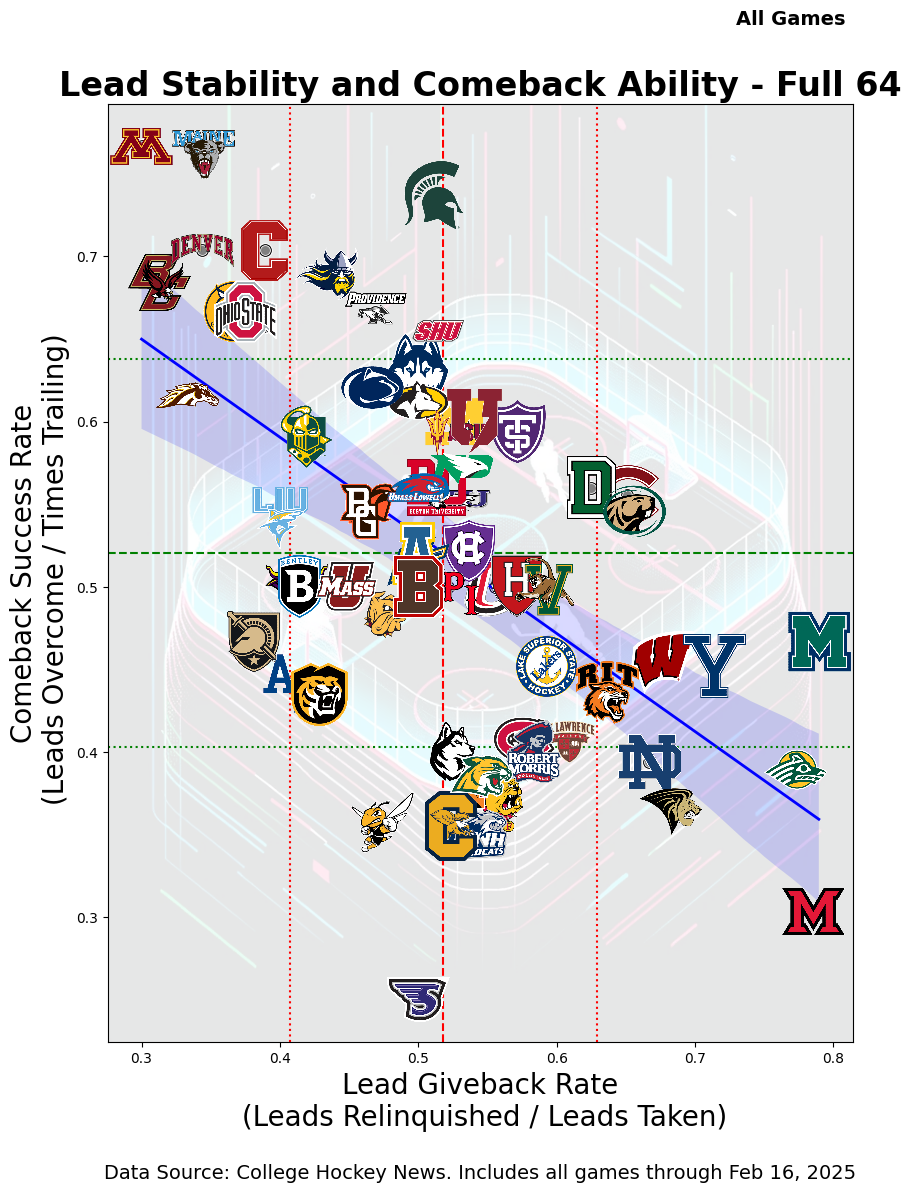

In [38]:
### Create Scatter Plot of Comeback vs Giveback Percentage

def create_scatter_lead_stability(group_title, teams_to_plot, conf_status):
    # Set the figure size
    plt.figure(figsize=set_fig_size)
    
    # Create a scatter plot of Highlighted Teams
    sns.scatterplot(data=summary_df[summary_df['Team'].isin(teams_to_plot)], 
                    x='Lead_Giveback_Pct', y='Trail_Comback_Pct', s=100, color='black')

    # Create base scatter plot of all teams
    sns.scatterplot(data=summary_df, x='Lead_Giveback_Pct', y='Trail_Comback_Pct', s=50, color='gray')

    # Add Trendline to the plot
    sns.regplot(data=summary_df, x='Lead_Giveback_Pct', y='Trail_Comback_Pct', scatter=False, color='blue', line_kws={'linewidth': 2})

    # Plot Average and Standard Deviation Lines
    avg_giveback = summary_df['Lead_Giveback_Pct'].mean()
    avg_comeback = summary_df['Trail_Comback_Pct'].mean()
    std_giveback = summary_df['Lead_Giveback_Pct'].std()
    std_comeback = summary_df['Trail_Comback_Pct'].std()
    plt.axvline(avg_giveback, color='red', linestyle='--', label='Average Giveback %')
    plt.axhline(avg_comeback, color='green', linestyle='--', label='Average Comeback %')
    plt.axvline(avg_giveback + std_giveback, color='red', linestyle=':', label='1 Std Dev Giveback %')
    plt.axvline(avg_giveback - std_giveback, color='red', linestyle=':')
    plt.axhline(avg_comeback + std_comeback, color='green', linestyle=':', label='1 Std Dev Comeback %')

    plt.axhline(avg_comeback - std_comeback, color='green', linestyle=':')

    # Add logos to the plot for each team in the specified group
    add_logos_to_plot(summary_df[summary_df['Team'].isin(teams_to_plot)], 
                      'Lead_Giveback_Pct', 'Trail_Comback_Pct', logo_mapping, logo_folder, plt.gca(), teams_to_plot)

    # Set the title and labels
    plt.title(f'Lead Stability and Comeback Ability - {group_title}', **font_scatter_title_param)
    plt.xlabel('Lead Giveback Rate\n (Leads Relinquished / Leads Taken)', **font_scatter_label_param)
    plt.ylabel('Comeback Success Rate\n (Leads Overcome / Times Trailing)', **font_scatter_label_param)

    # Get x and y limits for the plot
    xlim = plt.xlim()
    ylim = plt.ylim()
    

    # Set Background Image
    plt.imshow(bg_img, aspect='auto', extent=[xlim[0], xlim[1], ylim[0], ylim[1]], alpha=alpha_value)
    # Add a tag for conference filter status
    add_conf_tag_to_image(conf_status)

    # add a note with the date the data was pulled and plotted
    # last_game_date = scoring_df['Date'].max()
    ax = plt.gca()



    ax.text(0.5, -0.15, f'Data Source: College Hockey News. Includes all games through {last_game_date}', ha='center', va='bottom',
    # # ax.text(0.5, -0.20, f'Data Source: College Hockey News. Includes all games through 12/02/2024', ha='center', va='bottom',
     fontsize=14, 
    transform=ax.transAxes
    )

    # Set layout to tight
    plt.tight_layout()
    # Show the plot
    plt.show()

# Call the function to create the scatter plot
create_scatter_lead_stability(group_title, teams_to_plot, conf_setting)

In [ ]:
# ### Save summary_df to CSV for further analysis
# summary_file_path = os.path.join(temp_folder, f'expanded_lead_trail_aggregate_states_{conf_setting}.csv')
# summary_df.to_csv(summary_file_path, index=False)

In [ ]:
############# HOTFIX REPLACE ABREVIATIONS WITH FULL TEAM NAMES IF NEEDED ################
def clean_team_name(team_name):
    """
    Cleans the team name by removing unwanted characters.
    Args:
        team_name (str): Team name.

    Returns:
        str: Cleaned team name.
    """
    # Replace unwanted characters with an empty string
    return team_name.replace('-', ' ').replace('.', '').replace("'", '').strip()

## Load school infomation from arena_school_info.csv
school_info_df = pd.read_csv(os.path.join('..', 'data', 'arena_school_info.csv'))

# Create a dictionary for abbreviations to full team names
abbreviation_to_fullname = school_info_df.set_index('abv')['Team'].to_dict()

# Define a function to replace abbreviations in a column with full team names
def replace_abbreviations_with_fullnames(df, column_name, abbreviation_dict):
    """
    Replaces abbreviations in the specified column of a DataFrame with full team names.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the column to process.
        column_name (str): The column name where abbreviations need to be replaced.
        abbreviation_dict (dict): Dictionary mapping abbreviations to full names.
    
    Returns:
        pd.DataFrame: DataFrame with updated column values.
    """
    df[column_name] = df[column_name].replace(abbreviation_dict)
    return df
####################

# Replace abbreviations with full team names in the 'Team' column
scoring_df = replace_abbreviations_with_fullnames(scoring_df, 'Team', abbreviation_to_fullname)

# # Clean Up Team names using the clean_team_name function
# scoring_df['Team'] = scoring_df['Team'].apply(clean_team_name)

# Examine the abbreviation_to_fullname dictionary
# print(abbreviation_to_fullname)

In [ ]:


def calculate_game_states(scoring_df):
    """
    Calculate time spent in different game states (tied, leading by 1, leading by 2+, trailing by 1, etc.)
    for each team in each game.
    """
    # Initialize a dictionary to store results
    results = defaultdict(lambda: defaultdict(int))
    
    # Group by each game and sort by cumulative seconds
    games = scoring_df.groupby('Game_ID')
    
    for game_id, game_data in games:
        game_data = game_data.sort_values('Cumulative_Seconds')
        
        # Extract home and away teams
        home_team = game_data['Home_Team'].iloc[0]
        away_team = game_data['Away_Team'].iloc[0]
        
        # Initialize scores and time tracking
        scores = {home_team: 0, away_team: 0}
        previous_time = 0
        
        # Function to determine game state
        def get_game_state(team, scores):
            opponent = home_team if team == away_team else away_team
            goal_diff = scores[team] - scores[opponent]
            
            if goal_diff == 0:
                return 'Tied'
            elif goal_diff == 1:
                return 'Leading by 1'
            elif goal_diff == 2:
                return 'Leading by 2'
            elif goal_diff >= 3:
                return 'Leading by 3+'
            elif goal_diff == -1:
                return 'Trailing by 1'
            elif goal_diff == -2:
                return 'Trailing by 2'
            else:
                return 'Trailing by 3+'

        # Track the game states as goals are scored
        for _, row in game_data.iterrows():
            current_time = row['Cumulative_Seconds']
            elapsed_time = current_time - previous_time
            
            # Calculate the current state for both teams before the goal
            for team in [home_team, away_team]:
                state = get_game_state(team, scores)
                results[team][state] += elapsed_time
            
            # Update the score for the team that scored
            scores[row['Team']] += 1
            
            # Update the previous time to the current goal time
            previous_time = current_time
        
        # Handle the final game state after the last goal to the end of the game (60 or 65 minutes)
        game_end_time = 3900 if 'Overtime' in game_data['Period'].values else 3600
        remaining_time = game_end_time - previous_time
        
        for team in [home_team, away_team]:
            state = get_game_state(team, scores)
            results[team][state] += remaining_time

    # Convert results to a DataFrame for easy analysis
    result_df = pd.DataFrame(results).fillna(0).transpose()
    result_df.reset_index(inplace=True)
    result_df.rename(columns={'index': 'Team'}, inplace=True)
    
    return result_df

# Clean the Team names using the clean_team_name function
scoring_df['Team'] = scoring_df['Team'].apply(clean_team_name)

################# DEAD CODE #################
            # # Hotfix Add . back to St. Lawrence
            # scoring_df['Team'] = scoring_df['Team'].replace('St Lawrence', 'St. Lawrence')
            # # # St. Cloud State
            # scoring_df['Team'] = scoring_df['Team'].replace('St Cloud State', 'St. Cloud State')
            # # American Intl
            # scoring_df['Team'] = scoring_df['Team'].replace('American Intl', "American Int'l")
            # # Mass Lowell
            # scoring_df['Team'] = scoring_df['Team'].replace('Mass Lowell', 'Mass. Lowell')
            # # St Thomas
            # scoring_df['Team'] = scoring_df['Team'].replace('St Thomas', 'St. Thomas')


# Calculate the game states using the function
game_states_df = calculate_game_states(scoring_df)

# Output the game states to a CSV file for checking
game_states_df.to_csv(output_file_path, index=False)

# Display the result
# tools.display_dataframe_to_user(name="Team Game State Analysis", dataframe=game_states_df)


In [ ]:
# game_states_df
# Find instances with Mass Lowell in scoring_df
# scoring_df[scoring_df['Team'].str.contains('Mass Lowell')]


In [ ]:
# ## As a QCheck get a total time and divide by 60 to get minutes
# # Set the index to the team name
# game_states_df.set_index('Team', inplace=True)
# game_states_df['Total_Time'] = game_states_df.sum(axis=1)
# game_states_df['Total_Time_Minutes'] = game_states_df['Total_Time'] / 60


# game_states_df.head(10)

### Calculate percentages for each game state

In [ ]:
# Calculate the total time for each team and add the percentage columns
game_states_df['Total_Time'] = game_states_df[['Tied', 'Trailing by 1', 'Trailing by 2', 'Trailing by 3+',
                                               'Leading by 1', 'Leading by 2', 'Leading by 3+']].sum(axis=1)

# Calculate the percentage of time spent in each state
game_states_df['Tied_Percentage'] = game_states_df['Tied'] / game_states_df['Total_Time'] * 100
game_states_df['Leading_by_1_Percentage'] = game_states_df['Leading by 1'] / game_states_df['Total_Time'] * 100
game_states_df['Leading_by_2_Percentage'] = game_states_df['Leading by 2'] / game_states_df['Total_Time'] * 100
game_states_df['Leading_by_3+_Percentage'] = game_states_df['Leading by 3+'] / game_states_df['Total_Time'] * 100
game_states_df['Trailing_by_1_Percentage'] = game_states_df['Trailing by 1'] / game_states_df['Total_Time'] * 100
game_states_df['Trailing_by_2_Percentage'] = game_states_df['Trailing by 2'] / game_states_df['Total_Time'] * 100
game_states_df['Trailing_by_3+_Percentage'] = game_states_df['Trailing by 3+'] / game_states_df['Total_Time'] * 100

# Re-run the plotting function to visualize the top teams by leading percentage
# plot_top_teams_by_leading_percentage(game_states_df)




# Visualizations

#### Helper Functions

In [ ]:
### TEST CODE FOR NEW LEGEND

def add_refined_legend(ax, colors, legend_font_size=10):
    """
    Add a modern, streamlined legend to the plot with colors aligned horizontally,
    with two rows of text for the degree of lead/deficit and guide labels.
    """

    

    # Legend labels for the top row (inside the swatches)
    degree_labels = ["3+", "2", "1", "", "1", "2", "3+"]
    
    # Guide labels for the bottom row
    guide_labels = ["Lead", "Tied", "Trail"]
    
    # Calculate the position and width of the legend
    legend_x = 0.5  # Centered on the x-axis
    legend_width = 0.75  # Span 75% of the plot width

    # Create rectangles for each color swatch
    swatches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
    
    # Create a legend with swatches and the degree labels
    legend = ax.legend(
        swatches, degree_labels, loc='upper center',
        bbox_to_anchor=(legend_x, -0.075), ncol=len(colors), frameon=False,
        fontsize=legend_font_size, handlelength=7.0, 
        handletextpad=0.15, columnspacing=0.5
    )
    
    # Center the text inside the swatches
    for text, label in zip(legend.get_texts(), degree_labels):
        text.set_ha('center')
        text.set_va('center')

    # Add the bottom guide labels ("Lead", "Tied", "Down")
    ax.text(
        0.15, -0.15, guide_labels[0], ha='center', va='center', transform=ax.transAxes, fontsize=legend_font_size_2
    )
    ax.text(
        0.5, -0.15, guide_labels[1], ha='center', va='center', transform=ax.transAxes, fontsize=legend_font_size_2
    )
    ax.text(
        0.85, -0.15, guide_labels[2], ha='center', va='center', transform=ax.transAxes, fontsize=legend_font_size_2
    )
    
     # add a note with the date the data was pulled and plotted
    ax.text(0.5, -0.2, f'Data Source: College Hockey News. Includes all games through {last_game_date}', ha='center', va='bottom',
     fontsize=12, 
    transform=ax.transAxes
    )

### Options and Settings

In [ ]:
## Set the figure size / ratio
set_fig_size = (9, 10)

## Color Scheme from the Original Tableau Viz
colors = [
    '#1A9850', '#65BD62', '#A6D86A',  # Leading: Dark Blue, Light Blue, Steel Blue
    '#FFFFBF',                        # Tied: Dark Gray
    '#FCAE62', '#F36D42', '#D73026'   # Trailing: Light Red, Orange Red, Dark Red
]

#### Adjustable Plot Backend

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os

def plot_team_comparison(game_states_df, logo_mapping, logo_folder, plot_type, conf, top_n=10):
    """
    Plot stacked bar charts of game state percentages for the top `top_n` teams,
    with labels showing the percentage within each segment if space allows,
    and team logos replacing the team names on the y-axis.
    
    Parameters:
    - game_states_df: DataFrame containing game state data.
    - logo_mapping: Dictionary mapping team names to logo file names.
    - logo_folder: Folder path where logos are stored.
    - plot_type: Type of plot ("leading", "trailing", "tied", "least_tied").
    - top_n: Number of top teams to display.
    """
    
    # Calculate the total percentages for leading, trailing, and tied states
    game_states_df['Total_Leading_Percentage'] = (
        game_states_df['Leading_by_1_Percentage'] +
        game_states_df['Leading_by_2_Percentage'] +
        game_states_df['Leading_by_3+_Percentage']
    )
    game_states_df['Total_Trailing_Percentage'] = (
        game_states_df['Trailing_by_1_Percentage'] +
        game_states_df['Trailing_by_2_Percentage'] +
        game_states_df['Trailing_by_3+_Percentage']
    )
    game_states_df['Total_Tied_Percentage'] = game_states_df['Tied_Percentage']

    # Select the top teams based on the chosen plot type
    if plot_type == "leading":
        top_teams_df = game_states_df.nlargest(top_n, 'Total_Leading_Percentage')
        title = f"Highest % of Game Time Leading"
    elif plot_type == "trailing":
        top_teams_df = game_states_df.nlargest(top_n, 'Total_Trailing_Percentage')
        title = f"Highest % of Game Time Trailing"
    elif plot_type == "tied":
        top_teams_df = game_states_df.nlargest(top_n, 'Total_Tied_Percentage')
        title = f"Highest % of Game Time Tied"
    elif plot_type == "least_tied":
        top_teams_df = game_states_df.nsmallest(top_n, 'Total_Tied_Percentage')
        title = f"Lowest % of Game Time Tied"
    else:
        raise ValueError("Invalid plot type. Choose from 'leading', 'trailing', 'tied', 'least_tied'.")

    # Prepare data for plotting
    categories = [
        'Leading_by_3+_Percentage', 'Leading_by_2_Percentage', 'Leading_by_1_Percentage',
        'Tied_Percentage', 'Trailing_by_1_Percentage', 'Trailing_by_2_Percentage', 'Trailing_by_3+_Percentage'
    ]
    
    colors = [
        '#1A9850', '#65BD62', '#A6D86A',  # Leading: Shades of Green
        '#FFFFBF',                        # Tied: Yellow
        '#FCAE62', '#F36D42', '#D73026'   # Trailing: Shades of Red
    ]

    custom_labels = [
        'Lead 3+', 'Lead 2', 'Lead 1', 
        'Tied', 'Down 1', 'Down 2', 'Down 3+'
    ]
    
    fig, ax = plt.subplots(figsize=set_fig_size)
    
    bottom = None
    for category, color in zip(categories, colors):
        if bottom is None:
            bars = ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category)
            bottom = top_teams_df[category]
        else:
            bars = ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category, left=bottom)
            bottom += top_teams_df[category]
        
        # Add labels to the segments where there's enough space
        for bar, value in zip(bars, top_teams_df[category]):
            if value > 5:  # Only show labels if the segment is larger than 5%
                ax.text(
                    bar.get_x() + bar.get_width() / 2, 
                    bar.get_y() + bar.get_height() / 2, 
                    f"{value:.1f}%", ha='center', va='center', fontsize=12, color='black'
                )

    # Add team logos in place of the y-axis labels
    for i, team in enumerate(top_teams_df['Team']):
        logo_path = os.path.join(logo_folder, logo_mapping.get(team, ""))
        if logo_path and os.path.exists(logo_path):
            try:
                logo_img = plt.imread(logo_path)
                imagebox = OffsetImage(logo_img, zoom=0.15)
                ab = AnnotationBbox(imagebox, (0, i), frameon=False, boxcoords="offset points", 
                                    xybox=(-25, 0), pad=0, xycoords='data')
                ax.add_artist(ab)
            except Exception as e:
                print(f"Error adding logo for {team}: {e}")

    # Remove y-axis labels since we are using logos
    ax.set_yticks([])
    
    # Customize the chart
    ax.set_xlabel('Percentage of Game Time', fontsize=set_x_label_font_size)
    ax.set_title(title, fontsize=title_font_size)
    ax.set_xlim(0, 100)
    ax.set_xticks([25, 50, 75])



    # Legend labels for the top row (inside the swatches)
    degree_labels = ["3+", "2", "1", "", "1", "2", "3+"]
    
    # Guide labels for the bottom row
    guide_labels = ["Lead", "Tied", "Trail"]
    
    # Calculate the position and width of the legend
    legend_x = 0.5  # Centered on the x-axis
    # legend_width = 0.75  # Span 75% of the plot width

    # Create rectangles for each color swatch
    swatches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
    
    # Create a legend with swatches and the degree labels
    legend = ax.legend(
        swatches, degree_labels, loc='upper center',
        bbox_to_anchor=(legend_x, -0.065), ncol=len(colors), frameon=False,
        fontsize=legend_font_size_2, handlelength=3.5, 
        handletextpad=0.15, columnspacing=0.05
    )
    
    # Center the text inside the swatches
    for text, label in zip(legend.get_texts(), degree_labels):
        text.set_ha('center')
        text.set_va('center')

    # Add the bottom guide labels ("Lead", "Tied", "Down")
    ax.text(
        0.15, -0.15, guide_labels[0], ha='center', va='center', transform=ax.transAxes, fontsize=legend_font_size
    )
    ax.text(
        0.5, -0.15, guide_labels[1], ha='center', va='center', transform=ax.transAxes, fontsize=legend_font_size
    )
    ax.text(
        0.85, -0.15, guide_labels[2], ha='center', va='center', transform=ax.transAxes, fontsize=legend_font_size
    )


    
    # add a note with the date the data was pulled and plotted
    ax.text(0.5, -0.20, f'Data Source: College Hockey News. Includes all games through {last_game_date}', ha='center', va='bottom',
    # ax.text(0.5, -0.20, f'Data Source: College Hockey News. Includes all games through 12/02/2024', ha='center', va='bottom',
     fontsize=14, 
    transform=ax.transAxes
    )

    # ### ADDED 2-13-25
    add_conf_tag_to_image(conf)
    
    

    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.gca().invert_yaxis()

    # Save the plot as an image to the TEMP folder
    plot_filename = f"top_teams_{plot_type}_{conf}.png"
    plot_filepath = os.path.join(tie_plot_folder, plot_filename)
    plt.savefig(plot_filepath)

    
    # plt.show()


### Call The Plots

In [ ]:

# Example usage:
plot_team_comparison(game_states_df, logo_mapping, logo_folder, plot_type='leading', conf=conf_setting, top_n=10)
plot_team_comparison(game_states_df, logo_mapping, logo_folder, plot_type='trailing', conf=conf_setting, top_n=10)
plot_team_comparison(game_states_df, logo_mapping, logo_folder, plot_type='tied', conf=conf_setting, top_n=10)
plot_team_comparison(game_states_df, logo_mapping, logo_folder, plot_type='least_tied', conf=conf_setting, top_n=10)


In [ ]:
# ## Correct the names in the game_states_df to not have any non-letter characters
# # Reindex the game_states_df so Team is not the index
# game_states_df.reset_index(inplace=True)


# # print(game_states_df[game_states_df['Team'].str.contains('St. Lawrence')])

# # Remove periods from the team names
# game_states_df['Team'] = game_states_df['Team'].str.replace(r'\.', '')

# print(game_states_df[game_states_df['Team'].str.contains('St. Lawrence')])


In [ ]:
game_states_df.head()
# Find St. Lawrence
game_states_df[game_states_df['Team'].str.contains('American')]

## Call Plots by Conference

In [ ]:
## Define TEMP DIRECTORY FOR IMAGE OUTPUT
temp_output_tie_plot_folder = os.path.join(os.getcwd(), '..', 'TEMP', 'IMAGES', 'tie_plots')

### Dictionary of Team Names and Abbreviations


## Conference Membership

atlantic = ['Air Force', "American Intl", 'Army', 'Bentley', 'Canisius', 'Holy Cross', 'Mercyhurst', 
            'Niagara', 'RIT', 'Robert Morris', 'Sacred Heart']

big_ten = ['Michigan', 'Michigan State', 'Minnesota', 'Notre Dame', 'Ohio State', 'Penn State', 'Wisconsin']

ccha = ['Augustana', 'Bemidji State', 'Bowling Green', 'Ferris State', 'Lake Superior', 'Michigan Tech', 
        'Minnesota State', 'Northern Michigan', 'St Thomas']

ecac = ['Brown', 'Clarkson', 'Colgate', 'Cornell', 'Dartmouth', 'Harvard', 'Princeton', 'Quinnipiac',
        'Rensselaer', 'St Lawrence', 'Union', 'Yale']

hockey_east = ['Boston College', 'Boston University', 'Connecticut', 'Maine', 'Massachusetts', 'Mass Lowell',
                'Merrimack', 'New Hampshire', 'Northeastern', 'Providence', 'Vermont']

nchc = ['Arizona State', 'Colorado College', 'Denver', 'Miami', 'Minnesota Duluth', 'North Dakota', 'Omaha', 'St Cloud State',
        'Western Michigan']

independents = ['Alaska Anchorage', 'Alaska', 'Lindenwood', 'Long Island', 'Stonehill']

beanpot_2025 = ['Harvard', 'Boston University', 'Boston College', 'Northeastern']


#### Conference by Conference Plot Function

In [ ]:
# Create a function to call the plot_team_comparison function for each conference

def plot_conference_comparison(game_states_df, logo_mapping, logo_folder, conference, conference_text, conf, top_n=10):
    """
    Plot stacked bar charts of game state percentages for the top `top_n` teams within a conference,
    with labels showing the percentage within each segment if space allows,
    and team logos replacing the team names on the y-axis.
    
    Parameters:
    - game_states_df: DataFrame containing game state data.
    - logo_mapping: Dictionary mapping team names to logo file names.
    - logo_folder: Folder path where logos are stored.
    - conference: List of team names in the conference.
    - top_n: Number of top teams to display.
    """
    
    # Filter the game states data for teams in the conference
    conference_df = game_states_df[game_states_df['Team'].isin(conference)]
    
    # Calculate the total percentages for leading, trailing, and tied states
    conference_df['Total_Leading_Percentage'] = (
        conference_df['Leading_by_1_Percentage'] +
        conference_df['Leading_by_2_Percentage'] +
        conference_df['Leading_by_3+_Percentage']
    )
    conference_df['Total_Trailing_Percentage'] = (
        conference_df['Trailing_by_1_Percentage'] +
        conference_df['Trailing_by_2_Percentage'] +
        conference_df['Trailing_by_3+_Percentage']
    )
    conference_df['Total_Tied_Percentage'] = conference_df['Tied_Percentage']

    # Select the top teams based on the chosen plot type
    top_teams_df = conference_df.nlargest(top_n, 'Total_Leading_Percentage')
    title = f"{conference_text}: Game Balance"
    subtitle = f"By Percentage of Time with a Lead"
    
    # Prepare data for plotting
    categories = [
        'Leading_by_3+_Percentage', 'Leading_by_2_Percentage', 'Leading_by_1_Percentage',
        'Tied_Percentage', 'Trailing_by_1_Percentage', 'Trailing_by_2_Percentage', 'Trailing_by_3+_Percentage'
    ]
    
    colors = [
        '#1A9850', '#65BD62', '#A6D86A',  # Leading: Shades of Green
        '#FFFFBF',                        # Tied: Yellow
        '#FCAE62', '#F36D42', '#D73026'   # Trailing: Shades of Red
    ]

    custom_labels = [
        'Lead 3+', 'Lead 2', 'Lead 1',
        'Tied', 'Down 1', 'Down 2', 'Down 3+'
    ]

    fig, ax = plt.subplots(figsize=set_fig_size)

    bottom = None
    for category, color in zip(categories, colors):
        if bottom is None:
            bars = ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category)
            bottom = top_teams_df[category]
        else:
            bars = ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category, left=bottom)
            bottom += top_teams_df[category]

        # Add labels to the segments where there's enough space
        for bar, value in zip(bars, top_teams_df[category]):
            if value > 5:  # Only show labels if the segment is larger than 5%
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + bar.get_height() / 2,
                    f"{value:.1f}%", ha='center', va='center', fontsize=12, color='black'
                )

    # Add team logos in place of the y-axis labels
    for i, team in enumerate(top_teams_df['Team']):
        logo_path = os.path.join(logo_folder, logo_mapping.get(team, ""))
        if logo_path and os.path.exists(logo_path):
            try:
                logo_img = plt.imread(logo_path)
                imagebox = OffsetImage(logo_img, zoom=0.15)
                ab = AnnotationBbox(imagebox, (0, i), frameon=False, boxcoords="offset points",
                                    xybox=(-30, 0), pad=0, xycoords='data')
                ax.add_artist(ab)
            except Exception as e:
                print(f"Error adding logo for {team}: {e}")

    # Remove y-axis labels since we are using logos
    ax.set_yticks([])

    # Customize the chart
    ax.set_xlabel('Percentage of Game Time', fontsize=set_x_label_font_size)
    ax.set_title(title, fontsize=title_font_size)
    # Set subtitle
    ax.text(0.5, 0.96, subtitle, ha='center', va='bottom', fontsize=16, transform=ax.transAxes)
    ax.set_xlim(0, 100)
    ax.set_xticks([0, 25, 50, 75, 100]) # Major Tick Marks
    # Set style for major tick marks
    ax.tick_params(axis='x', which='major', length=10, width=1)
    # Set grid for major tick marks
    ax.grid(which='major', axis='x', linestyle='--', alpha=0.6)
    # Set minor Tick Marks every 10%
    ax.set_xticks([10, 20, 30, 40, 60, 70, 80, 90,], minor=True)
    # Girid lines for minor ticks
    ax.grid(which='minor', axis='x', linestyle=':', alpha=0.6)

    # Create a custom legend layout
    #        # Add the refined legend to the plot
    add_refined_legend(ax, colors)

    # Remove the border of the main plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ### ADD Tag for Conference Filter
    # ### ADDED 2-13-25
    add_conf_tag_to_image(conf_setting)
    

    # plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.gca().invert_yaxis()

    # Save the plot as an image in the TEMP folder
    output_filename = f"{conference_text}_game_balance_{conf}.png"
    # output_path = os.path.join(temp_output_tie_plot_folder, output_filename)
    output_path = os.path.join(temp_output_tie_plot_folder, output_filename)

    plt.savefig(output_path, bbox_inches='tight')


    # plt.show()


# Example usage:


### OUTPUT TOP

In [ ]:
## Beanpot 2025
# plot_conference_comparison(game_states_df, logo_mapping, logo_folder, conference=beanpot_2025, conference_text='Beanpot 2025', conf=conf_setting, top_n=4)


# Atlantic Hockey
plot_conference_comparison(game_states_df, logo_mapping, logo_folder, conference=atlantic, conference_text='Atlantic Hockey', conf=conf_setting, top_n=20)

#B1G
plot_conference_comparison(game_states_df, logo_mapping, logo_folder, conference=big_ten, conference_text='B1G', conf=conf_setting, top_n=20)

# Hockey East
plot_conference_comparison(game_states_df, logo_mapping, logo_folder, conference=hockey_east, conference_text='Hockey East', conf=conf_setting, top_n=20)

# ECAC
plot_conference_comparison(game_states_df, logo_mapping, logo_folder, conference=ecac, conference_text='ECAC', conf=conf_setting, top_n=20)

# NCHC
plot_conference_comparison(game_states_df, logo_mapping, logo_folder, conference=nchc, conference_text='NCHC', conf=conf_setting, top_n=20)

# CCHA
plot_conference_comparison(game_states_df, logo_mapping, logo_folder, conference=ccha, conference_text='CCHA', conf=conf_setting, top_n=20)

# Independents
plot_conference_comparison(game_states_df, logo_mapping, logo_folder, conference=independents, conference_text='Independents', conf=conf_setting, top_n=10)



## Full 64 Plot in Large format


In [ ]:
### Plot the entire range of teams softed by time with a lead.

# The aspect ration willl be different for this plot - x10 - y 40? - 50?

tall_fig_size = (10, 35)

def plot_all_teams(game_states_df, logo_mapping, logo_folder, conf, top_n=65):
    """
    Plot stacked bar charts of game state percentages for the top `top_n` teams,
    with labels showing the percentage within each segment if space allows,
    and team logos replacing the team names on the y-axis.
    
    Parameters:
    - game_states_df: DataFrame containing game state data.
    - logo_mapping: Dictionary mapping team names to logo file names.
    - logo_folder: Folder path where logos are stored.
    - top_n: Number of top teams to display.
    """
    
    # Calculate the total percentages for leading, trailing, and tied states
    game_states_df['Total_Leading_Percentage'] = (
        game_states_df['Leading_by_1_Percentage'] +
        game_states_df['Leading_by_2_Percentage'] +
        game_states_df['Leading_by_3+_Percentage']
    )
    game_states_df['Total_Trailing_Percentage'] = (
        game_states_df['Trailing_by_1_Percentage'] +
        game_states_df['Trailing_by_2_Percentage'] +
        game_states_df['Trailing_by_3+_Percentage']
    )
    game_states_df['Total_Tied_Percentage'] = game_states_df['Tied_Percentage']

    # Select the top teams based on the chosen plot type
    top_teams_df = game_states_df.nlargest(top_n, 'Total_Leading_Percentage')
    
    ############ SET THE TITLES ###############
    subtitle = f"% of Game Time with a Lead"
    title = f"Game Balance\n"
    

    # Prepare data for plotting
    categories = [
        'Leading_by_3+_Percentage', 'Leading_by_2_Percentage', 'Leading_by_1_Percentage',
        'Tied_Percentage', 'Trailing_by_1_Percentage', 'Trailing_by_2_Percentage', 'Trailing_by_3+_Percentage'
    ]
    
    colors = [
        '#1A9850', '#65BD62', '#A6D86A',  # Leading: Shades of Green
        '#FFFFBF',                        # Tied: Yellow
        '#FCAE62', '#F36D42', '#D73026'   # Trailing: Shades of Red
    ]

    custom_labels = [
        'Lead 3+', 'Lead 2', 'Lead 1',
        'Tied', 'Down 1', 'Down 2', 'Down 3+'
    ]

    # Sort by the total percentage of time leading
    top_teams_df = top_teams_df.sort_values('Total_Leading_Percentage', ascending=True)

    fig, ax = plt.subplots(figsize=tall_fig_size)

    # Adjust the spacing between the title, bars, and the legend
    plt.subplots_adjust(
        # top=0.92,   # Reduce space above the bar chart
        top = 1.0,
        bottom=0.15,  # Reduce space below the chart
        left=0.05,  # Leave some space on the left
        right=0.95  # Leave some space on the right
    )

    bottom = None
    for category, color in zip(categories, colors):
        if bottom is None:
            bars = ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category)
            bottom = top_teams_df[category]
        else:
            bars = ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category, left=bottom)
            bottom += top_teams_df[category]

        # Add labels to the segments where there's enough space
        for bar, value in zip(bars, top_teams_df[category]):
            if value > 5:  # Only show labels if the segment is larger than 5%
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + bar.get_height() / 2,
                    f"{value:.1f}%", ha='center', va='center', fontsize=12, color='black'
                )

    # Add team logos in place of the y-axis labels
    for i, team in enumerate(top_teams_df['Team']):
        logo_path = os.path.join(logo_folder, logo_mapping.get(team, ""))
        if logo_path and os.path.exists(logo_path):
            try:
                logo_img = plt.imread(logo_path)
                imagebox = OffsetImage(logo_img, zoom=0.10)
                ab = AnnotationBbox(imagebox, (0, i), frameon=False, boxcoords="offset points",
                                    xybox=(-30, 0), pad=0, xycoords='data')
                ax.add_artist(ab)
            except Exception as e:
                print(f"Error adding logo for {team}: {e}")

    # Remove y-axis labels since we are using logos
    ax.set_yticks([])

    # Customize the chart
    ax.set_xlabel('Percentage of Game Time', fontsize=set_x_label_font_size_2)
    ax.set_title(title, fontsize=title_font_size)
    # Add a Subtitle
    ax.text(0.5, 1.02, subtitle, ha='center', va='top', fontsize=16, transform=ax.transAxes)

    
    
    ## SET THE TICK MARK AND GRID LINE STYLE OPTIONS
    ax.set_xlim(0, 100)
    ax.set_xticks([0, 25, 50, 75, 100]) # Major Tick Marks
    # Add solid grid lines for major tick marks
    ax.grid(which='major', axis='x', linestyle='-', alpha=0.6)
    # Set minor Tick Marks every 10%
    ax.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], minor=True)
    # Girid lines for minor ticks
    ax.grid(which='minor', axis='x', linestyle='--', alpha=0.2)

    # add the tick labels to the top of the plot
    ax.xaxis.tick_top()

    # Set y axis limits - ADJUSTS THE EMPTY HEAD SPACE ABOVE THE BARS
    ax.set_ylim(-0.15, len(top_teams_df) - 0.5)

    # Create a custom legend layout
    ## Cutomized from original refined_legend function - 
    def tall_sheet_legend(ax, colors, legend_font_size=12):
        """
        Add a modern, streamlined legend to the plot with colors aligned horizontally,
        with two rows of text for the degree of lead/deficit and guide labels.
        """
        degree_labels = ["3+", "2", "1", "", "1", "2", "3+"]
        guide_labels = ["Lead", "Tied", "Trail"]
        
        legend_x = 0.5
        legend_y = -0.025  # Lower the legend to create more space
        legend_width = 0.95

        # Create rectangles for each color swatch
        swatches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]

        # Create a legend with swatches and the degree labels
        legend = ax.legend(
            swatches, degree_labels, loc='upper center',
            bbox_to_anchor=(legend_x, legend_y), ncol=len(colors), frameon=False,
            fontsize=legend_font_size_2, handlelength=4, 
            handletextpad=0.05, columnspacing=0.5
        #     swatches, degree_labels, loc='upper center',
        #     bbox_to_anchor=(legend_x, legend_y), ncol=len(colors), frameon=False,
        #     fontsize=legend_font_size, handlelength=2.5, handletextpad=0.2, columnspacing=1
        )
                

        for text, label in zip(legend.get_texts(), degree_labels):
            text.set_ha('center')
            text.set_va('center')

        set_offset = -0.05  # Lower the guide labels to create more space
        ax.text(
            0.15, set_offset, guide_labels[0], ha='center', va='center', transform=ax.transAxes, fontsize=legend_title_font_size
        )
        ax.text(
            0.5, set_offset, guide_labels[1], ha='center', va='center', transform=ax.transAxes, fontsize=legend_title_font_size
        )
        ax.text(
            0.85, set_offset, guide_labels[2], ha='center', va='center', transform=ax.transAxes, fontsize=legend_title_font_size
        )
        # # Add the date the data was pulled and plotted

                
        ax.text(
            0.5, set_offset + 0.025, 
            f'Data Source: College Hockey News. Includes all games through {last_game_date}', ha='center', va='center',
            fontsize=12, transform=ax.transAxes

        )


    # Add the updated legend to the plot
    tall_sheet_legend(ax, colors)

    add_conf_tag_to_image_tall_ver(conf_setting)

    # Remove the border of the main plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Save the plot as an image in the TEMP folder
    output_filename = f"all_teams_game_balance_{conf}.png"
    output_path = os.path.join(temp_output_tie_plot_folder, output_filename)

    # Adjust bottom margin and save the plot
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0.5)
    # plt.show()



In [ ]:
# Call the function to plot all teams
plot_all_teams(game_states_df, logo_mapping, logo_folder, conf=conf_setting, top_n=64)

#### Plot the all 64 by pairwise rank

# Scratch Area

In [ ]:
import time
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

# Step 1: Set up Chrome options
options = Options()
options.add_argument('--headless')  # Run in headless mode (no browser window)
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

# Step 2: Initialize the WebDriver
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# Step 3: Open the webpage
url = 'https://www.collegehockeynews.com/ratings/pairwise/'
driver.get(url)

try:
    # Step 4: Wait for the table to be present in the DOM
    wait = WebDriverWait(driver, 10)
    table = wait.until(EC.presence_of_element_located((By.TAG_NAME, 'table')))
    
    # Step 5: Debugging - Print the page source to verify if the table exists
    print("Page source length:", len(driver.page_source))

    # Step 6: Extract headers
    headers = [th.text for th in table.find_elements(By.TAG_NAME, 'th')]
    
    # Step 7: Extract rows
    rows = []
    for row in table.find_elements(By.TAG_NAME, 'tr')[1:]:  # Skip the header row
        cells = [cell.text for cell in row.find_elements(By.TAG_NAME, 'td')]
        if cells:
            rows.append(cells)

    # Step 8: Convert to DataFrame
    df = pd.DataFrame(rows, columns=headers)

    # Step 9: Display the DataFrame
    print(df)

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the browser
    driver.quit()


In [ ]:
df.head(25)


In [ ]:

## Join the Pairwise Rankings with the Game States Data

# Clean trouble Team names
# Replace Alaska-Anchorage with Alaska Anchorage
df['Team'] = df['Team'].str.replace('Alaska-Anchorage', 'Alaska Anchorage')
# Minnesota-Duluth with Minnesota Duluth
df['Team'] = df['Team'].str.replace('Minnesota-Duluth', 'Minnesota Duluth')
## Mass.-Lowell with Mass. Lowell
df['Team'] = df['Team'].str.replace('Mass.-Lowell', 'Mass. Lowell')


# Step 1: Merge the Pairwise Rankings with the Game States Data
merged_df = pd.merge(df, game_states_df, how='outer', left_on='Team', right_on='Team')

# Step 2: Display the info on the merged DataFrame to check for unexpected null values
print(merged_df.info())

# Output a csv file with the merged data for manual inspection
merged_output_path = os.path.join(temp_folder, 'merged_pairwise_game_states.csv')
merged_df.to_csv(merged_output_path, index=False)

In [ ]:
merged_df.to_csv(merged_output_path, index=False)